## **F1L Notebook 3.2 of 3: The KSQ**

This notebook follows the third part (3 of 3) of the FigureOne Lab Internship Emulator developed by Dean Lee. Here, I wrote a script to examine whether how various cancer cells co-express drug-related targets using using pseudobulk data. The reason to use pseudobulk data is to avoid dropouts (too many zero in expression matrix among single cells produce NA's in correlation matrix).

In [1]:
# install additional packages
! pip install --quiet anndata scanpy igraph leidenalg decoupler
# !pip install --quiet decoupler

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.3/126.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 6.1 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import pandas as pd
import scipy
import anndata
import scanpy as sc
import decoupler as dc
import seaborn as sns
import matplotlib.pyplot as plt
import re
from itertools import product
import matplotlib.colors as mcolors
import gc
pd.options.display.max_rows = 4000

# set up warning for cleaner code
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

from google.colab import drive
drive.mount('/content/drive')

# save for future code reproducibility
!pip freeze > requirements_scanpy.txt

/usr/local/lib/python3.11/dist-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Mounted at /content/drive


### 1. Generating Pseudobulk Data using raw data
To generate pseudobulk data I'll use package `decoupler` that takes raw count data as input. Therefore, I will reuse the code from notebook#1 to download and reprocess raw data.

In [3]:
# After signing into SCP, generate temporary curl download link with 'Bulk download
# The auth_code token can only be used once
!curl --insecure "https://singlecell.broadinstitute.org/single_cell/api/v1/bulk_download/generate_curl_config?accessions=SCP542&auth_code=PoorqDaL&directory=all&context=study"  -o cfg.txt

# Search for Metadata.txt and UMIcount_data.txt
! mkdir data
! grep "Metadata.txt" cfg.txt | grep -oP 'url="[^"]+"' | sed 's/url="//;s/"$//' | \
  xargs -I {} wget --quiet -O data/Metadata.txt {} || echo "Download failed"

! grep "UMIcount_data.txt" cfg.txt | grep -oP 'url="[^"]+"' | sed 's/url="//;s/"$//' | \
  xargs -I {} wget --quiet -O data/UMIcount_data.txt {} || echo "Download failed"

# List the Data directory for confirmation
! ls -la data/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 16260    0 16260    0     0  10716      0 --:--:--  0:00:01 --:--:-- 10711
total 3402224
drwxr-xr-x 2 root root       4096 Jan 23 23:58 .
drwxr-xr-x 1 root root       4096 Jan 23 23:58 ..
-rw-r--r-- 1 root root    8901512 Aug 18  2022 Metadata.txt
-rw-r--r-- 1 root root 3474960024 Aug 18  2022 UMIcount_data.txt


In [4]:
# Read in meta data
meta = pd.read_csv('/content/data/Metadata.txt', sep='\t')
meta.drop([0], axis=0, inplace=True) # drop the first row (specifying column dtypes)
meta.rename(columns={'NAME':'CellID', 'Cell_line':'CellLine', 'Pool_ID':'Pool', 'Cancer_type':'Indication'}, inplace=True)

# Get cell ID as rows
# First row is cell id, Second row is Cell line, Third row is Pool ID
counts_cellid = pd.read_csv('/content/data/UMIcount_data.txt', nrows=1, sep='\t', header=None)
counts_cellid = counts_cellid.transpose()
counts_cellid.drop([0], inplace=True)

# Read in all raw count data
counts = pd.read_csv('/content/data/UMIcount_data.txt', sep='\t', skiprows=3, header=None, index_col=0)
counts = counts.transpose()

# Assign counts index with counts_cellid
# Filter for cells that have meta data info
counts.index = counts_cellid[0]
counts.index.name = None
a = counts.index.isin(meta['CellID'])
counts = counts[a]

# Check to make sure all cells in counts are in meta
# Assign and reindex meta. Reindex arrange df such that rows are in the order of reindex
# If the LHS df doesn't have the RHS index. It'll produce NA
meta = meta.set_index('CellID')
meta = meta.reindex(index=counts.index)

# Check if counts equal meta
counts.index.equals(meta.index)

adata = anndata.AnnData(X=scipy.sparse.csr_matrix(counts),
                        obs=meta,
                        var=counts.columns.to_frame())
del counts
adata.var.drop(columns=[0], inplace=True)
adata.var.index.name = None

# Make sure dtypes for metadata is correct
adata.obs['CellLine'] = adata.obs['CellLine'].astype(str)
adata.obs['Pool'] = adata.obs['Pool'].astype(str)
adata.obs['Indication'] = adata.obs['Indication'].astype(str)
adata.obs['Genes_expressed'] = adata.obs['Genes_expressed'].astype(int)
adata.obs['Discrete_cluster_minpts5_eps1.8'] = adata.obs['Discrete_cluster_minpts5_eps1.8'].astype(str)
adata.obs['Discrete_cluster_minpts5_eps1.5'] = adata.obs['Discrete_cluster_minpts5_eps1.5'].astype(str)
adata.obs['Discrete_cluster_minpts5_eps1.2'] = adata.obs['Discrete_cluster_minpts5_eps1.2'].astype(str)
adata.obs['CNA_subclone'] = adata.obs['CNA_subclone'].astype(str)
adata.obs['SkinPig_score'] = adata.obs['SkinPig_score'].astype(float)
adata.obs['EMTI_score'] = adata.obs['EMTI_score'].astype(float)
adata.obs['EMTII_score'] = adata.obs['EMTII_score'].astype(float)
adata.obs['EMTIII_score'] = adata.obs['EMTIII_score'].astype(float)
adata.obs['IFNResp_score'] = adata.obs['IFNResp_score'].astype(float)
adata.obs['p53Sen_score'] = adata.obs['p53Sen_score'].astype(float)
adata.obs['EpiSen_score'] = adata.obs['EpiSen_score'].astype(float)
adata.obs['StressResp_score'] = adata.obs['StressResp_score'].astype(float)
adata.obs['ProtMatu_score'] = adata.obs['ProtMatu_score'].astype(float)
adata.obs['ProtDegra_score'] = adata.obs['ProtDegra_score'].astype(float)
adata.obs['G1/S_score'] = adata.obs['G1/S_score'].astype(float)
adata.obs['G2/M_score'] = adata.obs['G2/M_score'].astype(float)

<ipython-input-4-1cc144d96c71>:2: DtypeWarning: Columns (4,9,10,11,12,13,14,15,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv('/content/data/Metadata.txt', sep='\t')


In [5]:
def BasicScanpyPreprocessing(adata, n_top_genes=2000, n_neighbors=10, n_pcs=40, random_state=20):
    """BasicScanpyPreprocessing with additional data storing in layers"""
    # Store raw counts in layers
    adata.X = np.round(adata.X)
    adata.layers['counts'] = adata.X

    # Normalize and log transform
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.layers['normalized'] = adata.X

    sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor='seurat')
    #sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, random_state=random_state)
    sc.tl.umap(adata, random_state=random_state)
    sc.tl.leiden(adata, random_state=random_state)
    return adata

In [6]:
adata = BasicScanpyPreprocessing(adata,
                                 n_top_genes=2000,
                                 n_neighbors=10,
                                 n_pcs=40,
                                 random_state=40)

### 2. Use `Decoupler` to generate pseudobulk profiles

In [29]:
# Get filtered pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata,
    layer='counts',
    sample_col='Pool',
    groups_col='CellLine',
    mode='sum',
    min_cells=10,
    min_counts=1000,
    skip_checks=True
)

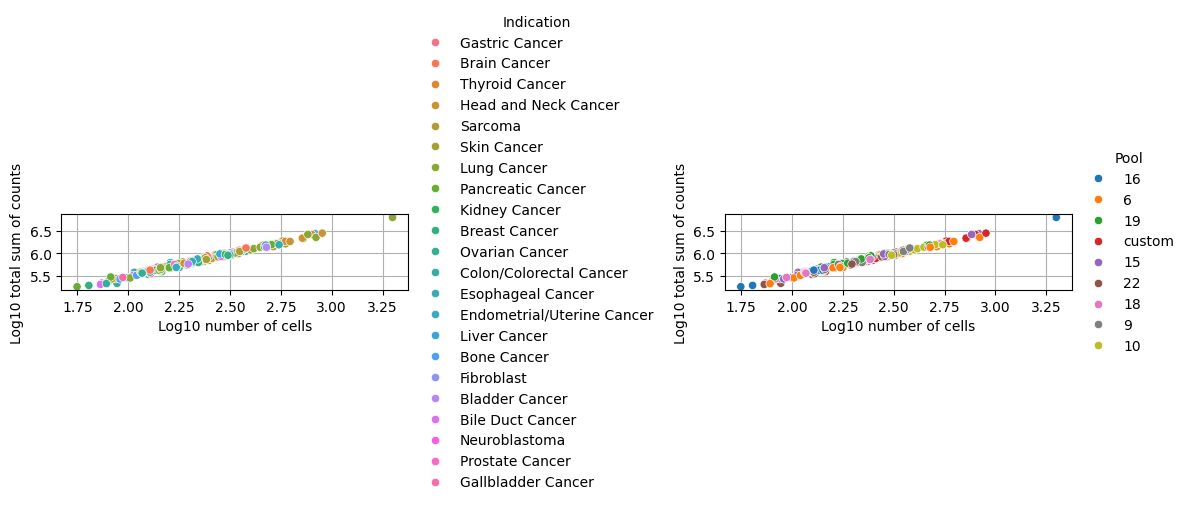

In [30]:
dc.plot_psbulk_samples(pdata, groupby=['Indication','Pool'], figsize=(12, 4))

In [14]:
# write out results
# adata.write('/content/drive/MyDrive/Datascience/kinker_etal_processed_data/240703_2_kinker_anndata_pseudobulk.h5ad')
# adata.write('/content/240703_2_kinker_anndata_pseudobulk.h5ad')

### 3. Explore some gene coexpression
Here, I will focus on `gene_list_ERBB2` and `gene_list_VEGF` data, because it is possible that cell lines that have similar expression patterns of these targets could respond to these mAb the same way (an assumptioo).

> For Trastuzumab

We observed ~4 clusters that we can confidently and visually identify from the diagonal axis of the matrix. I mentioned before that there are a few cell lines we may want to follow up on:
* Majority of Colon/Colorectal cancer cell lines (except SNUC4)
* HEC6 cell line for Endometrial/Uterine Cancer
* KYSE520 for Esophageal cancers

In [39]:
cell_lines = pdata.obs['CellLine'].unique()  # Get unique cell lines
cell_line_type = pd.CategoricalDtype(categories=cell_lines, ordered=False)  # Create categorical data type
pdata.obs['CellLine'] = pdata.obs['CellLine'].astype(cell_line_type)  # Convert the column

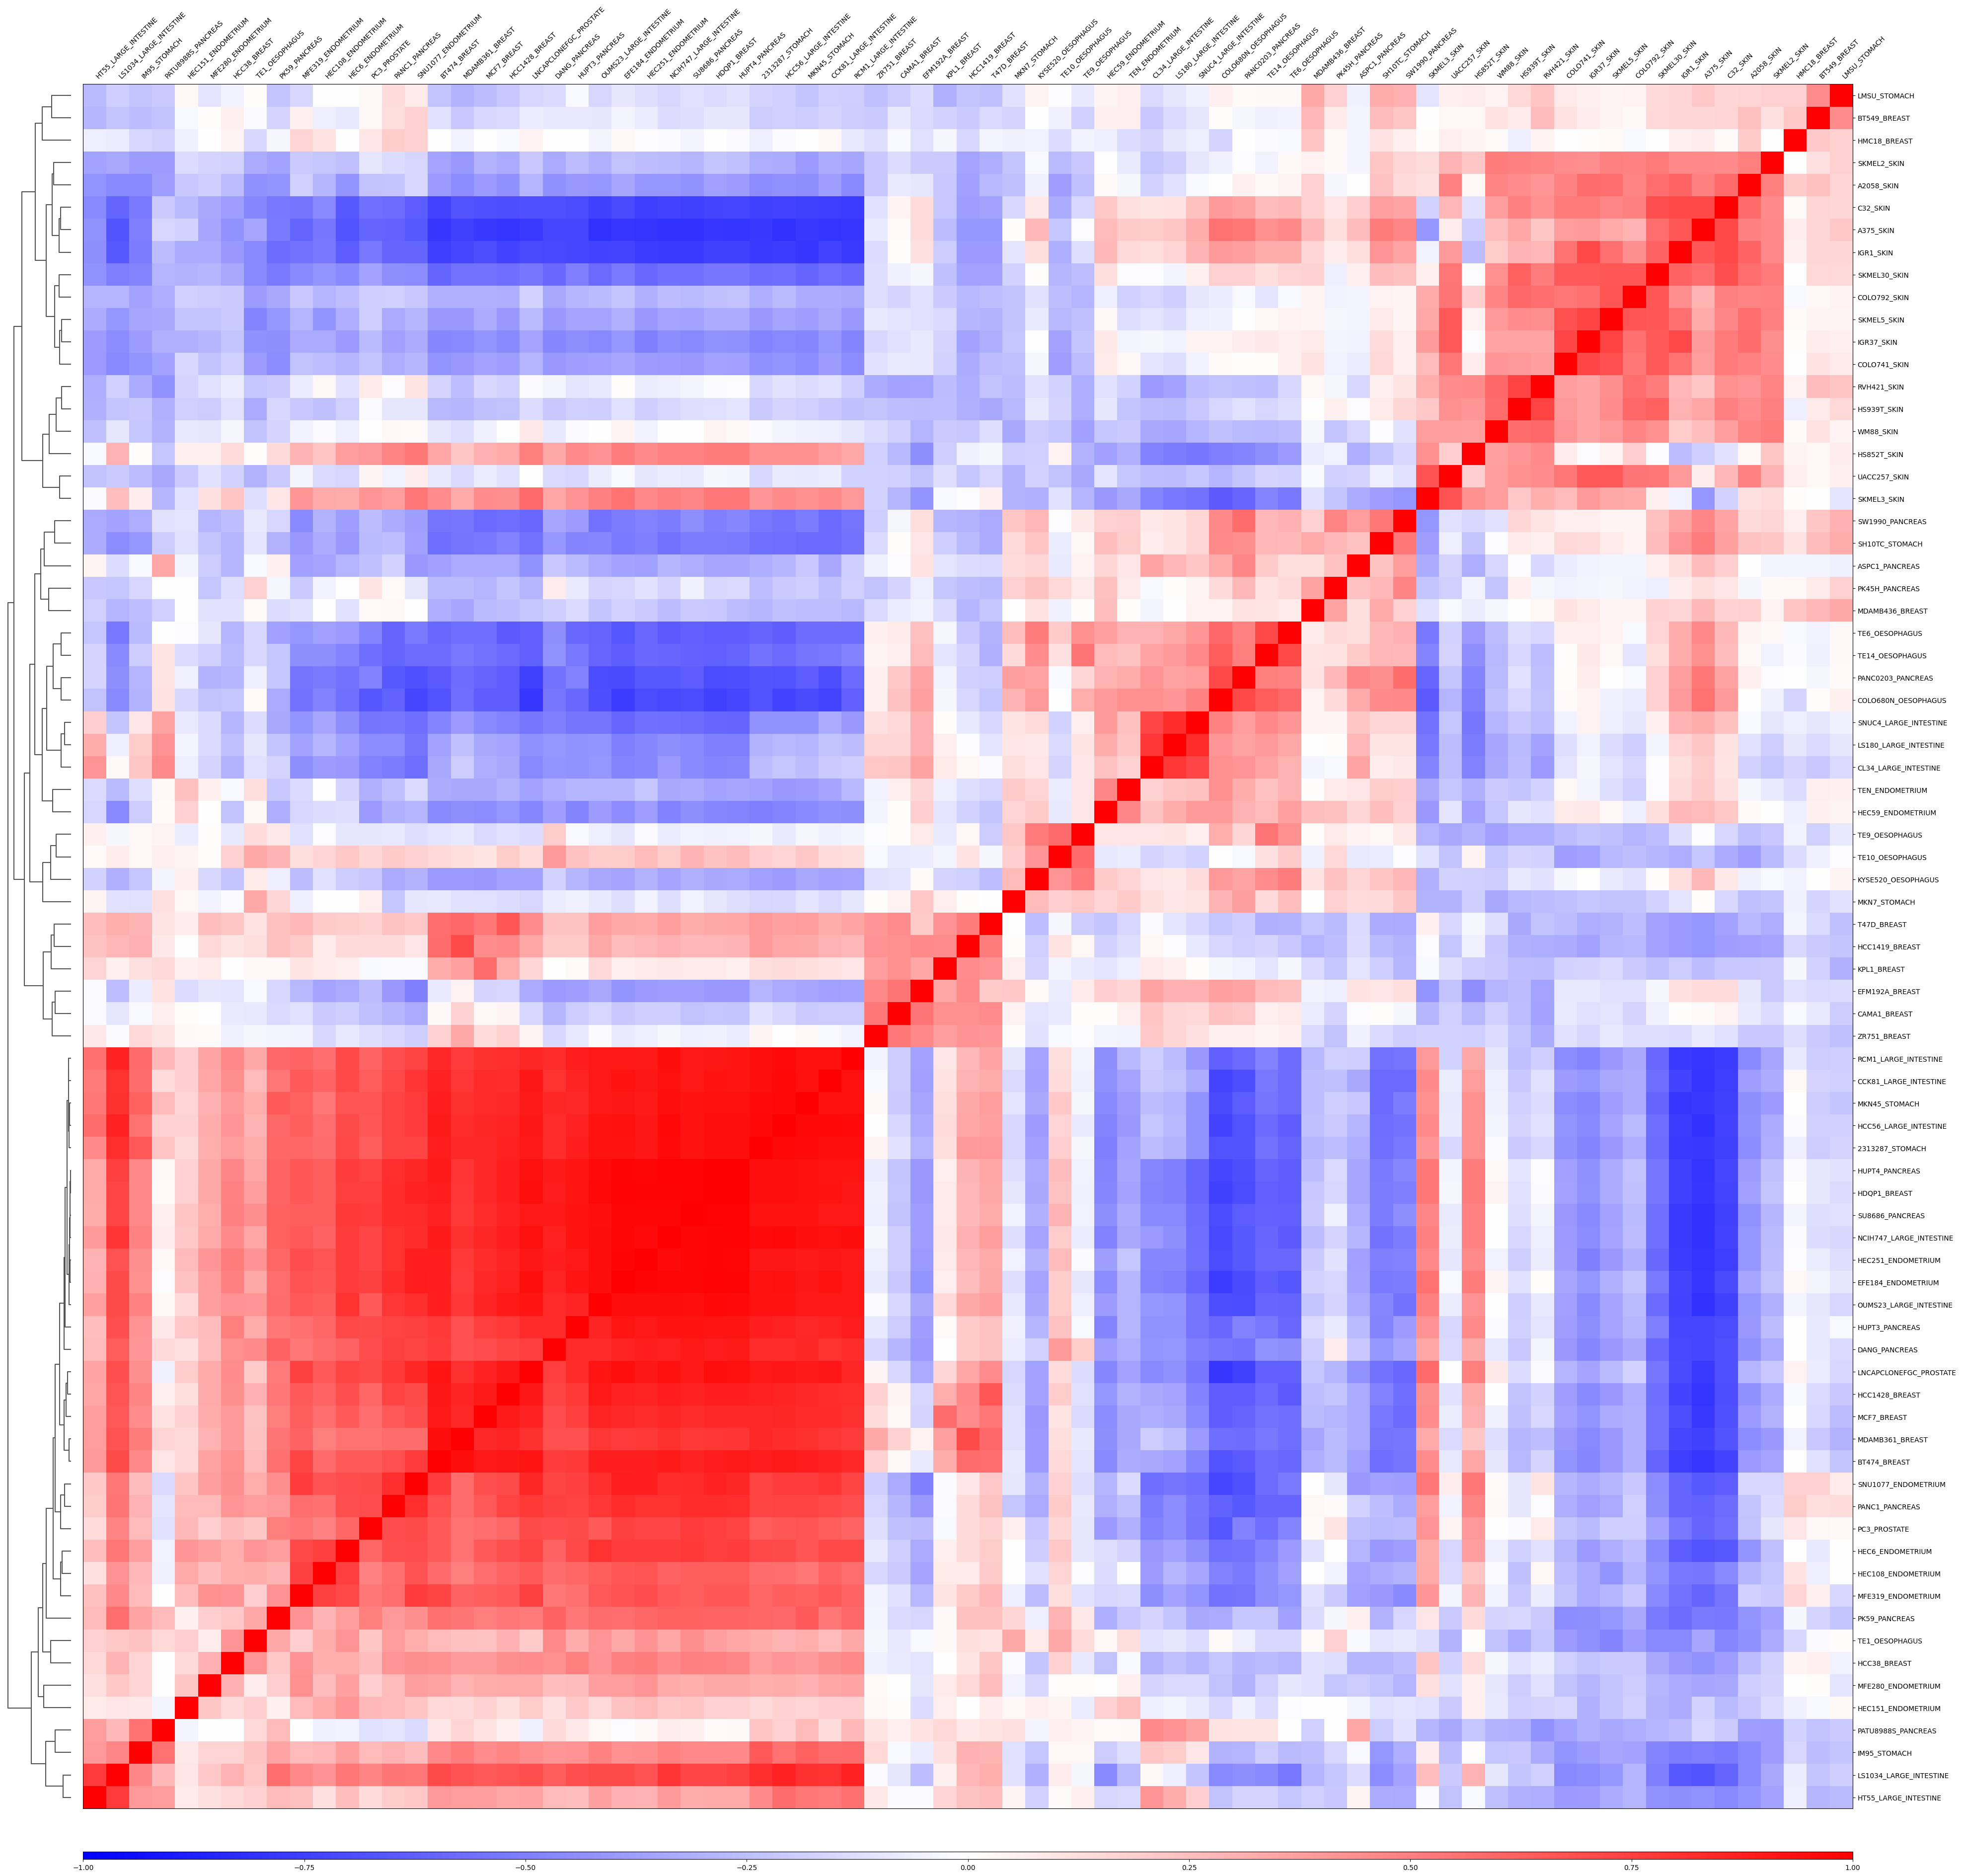

In [54]:
# ERBB2 gene list
# gene_list_ERBB2 = ['ERBB2', 'EGFR', 'ERBB3', 'ERBB4']

cancer_list_Trastuzumab = ['Breast Cancer', 'Gastric Cancer', 'Colon/Colorectal Cancer',
                           'Endometrial/Uterine Cancer', 'Esophageal Cancer',
                           'Skin Cancer', 'Prostate Cancer','Pancreatic Cancer']

pdata_Trastuzumab = pdata[pdata.obs['Indication'].isin(cancer_list_Trastuzumab)]

sc.tl.dendrogram(adata=pdata_Trastuzumab, groupby='CellLine')
sc.pl.correlation_matrix(adata=pdata_Trastuzumab, groupby='CellLine')

> Bevacizumab

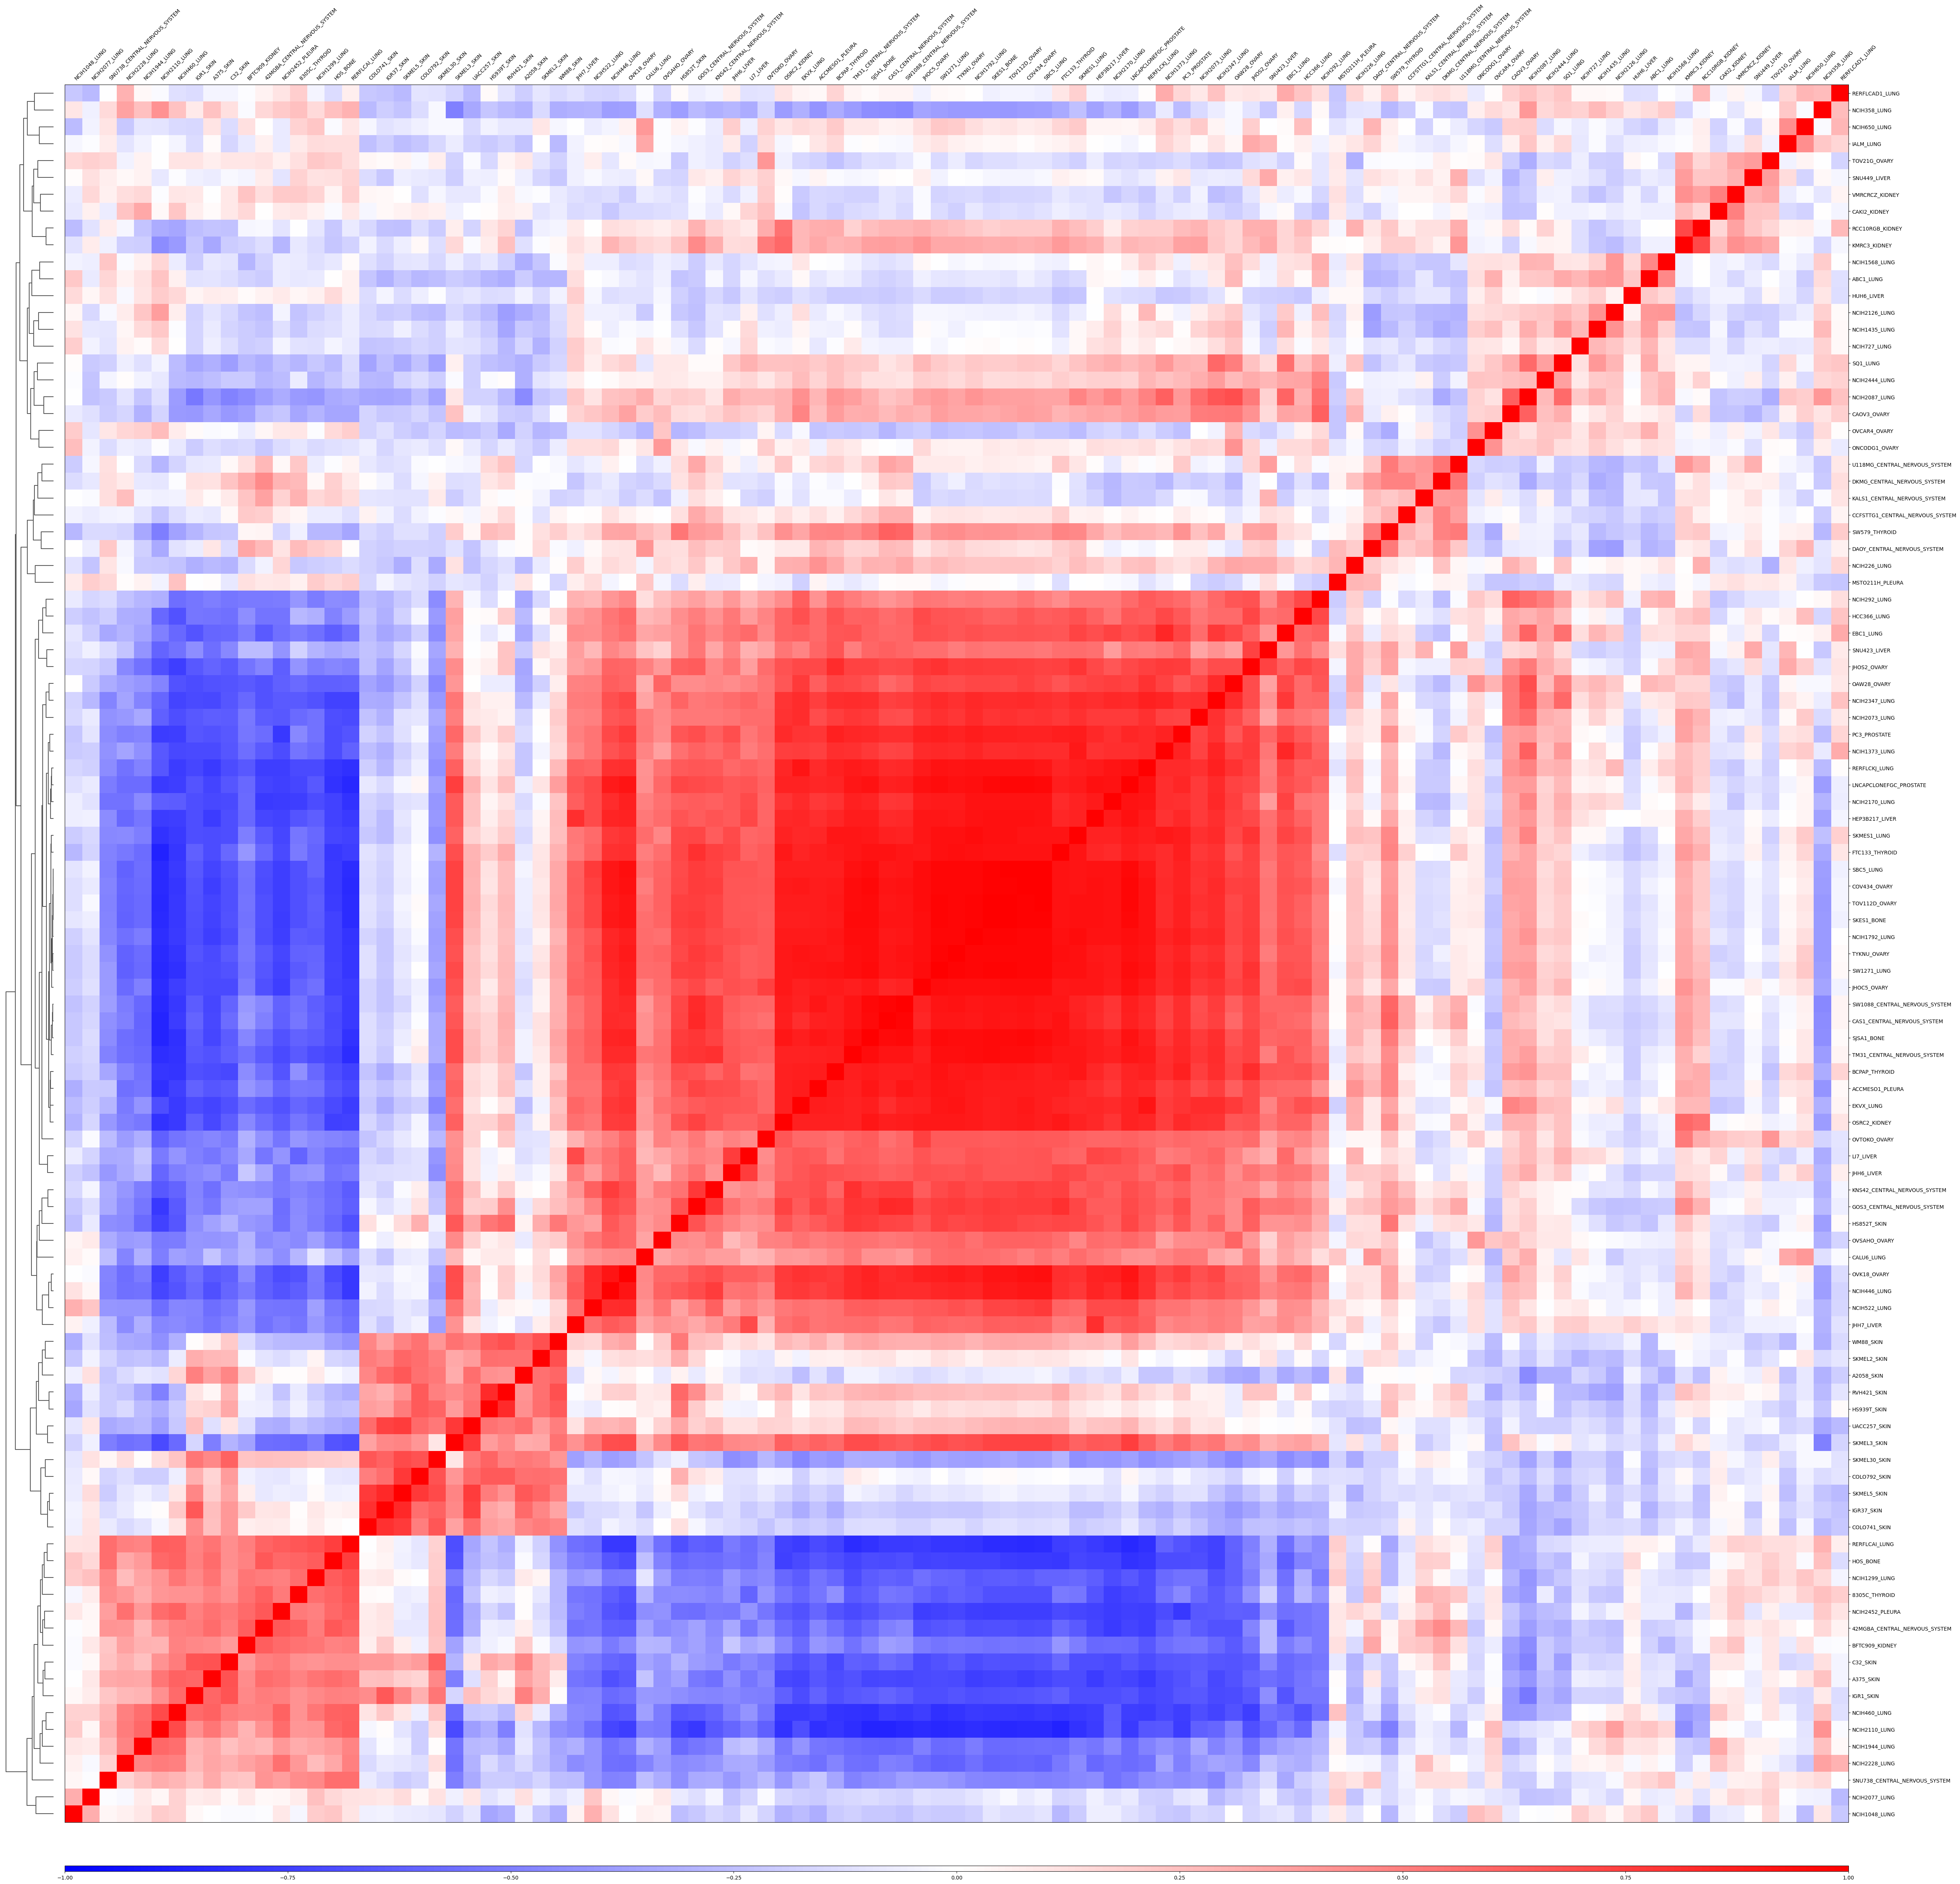

In [45]:
# VEGF gene list
# gene_list_VEGF = ['VEGFA', 'FLT1', 'KDR']

cancer_list_Bevacizumab = ['Lung Cancer', 'Brain Cancer', 'Liver Cancer', 'Kidney Cancer',
                           'Thyroid Cancer', 'Prostate Cancer', 'Skin Cancer', 'Bone Cancer', 'Ovarian Cancer']
pdata_Bevacizumab = pdata[pdata.obs['Indication'].isin(cancer_list_Bevacizumab)]

sc.tl.dendrogram(adata=pdata_Bevacizumab, groupby='CellLine')
sc.pl.correlation_matrix(adata=pdata_Bevacizumab, groupby='CellLine')

> Co-expression of ERBB2 signaling pathway


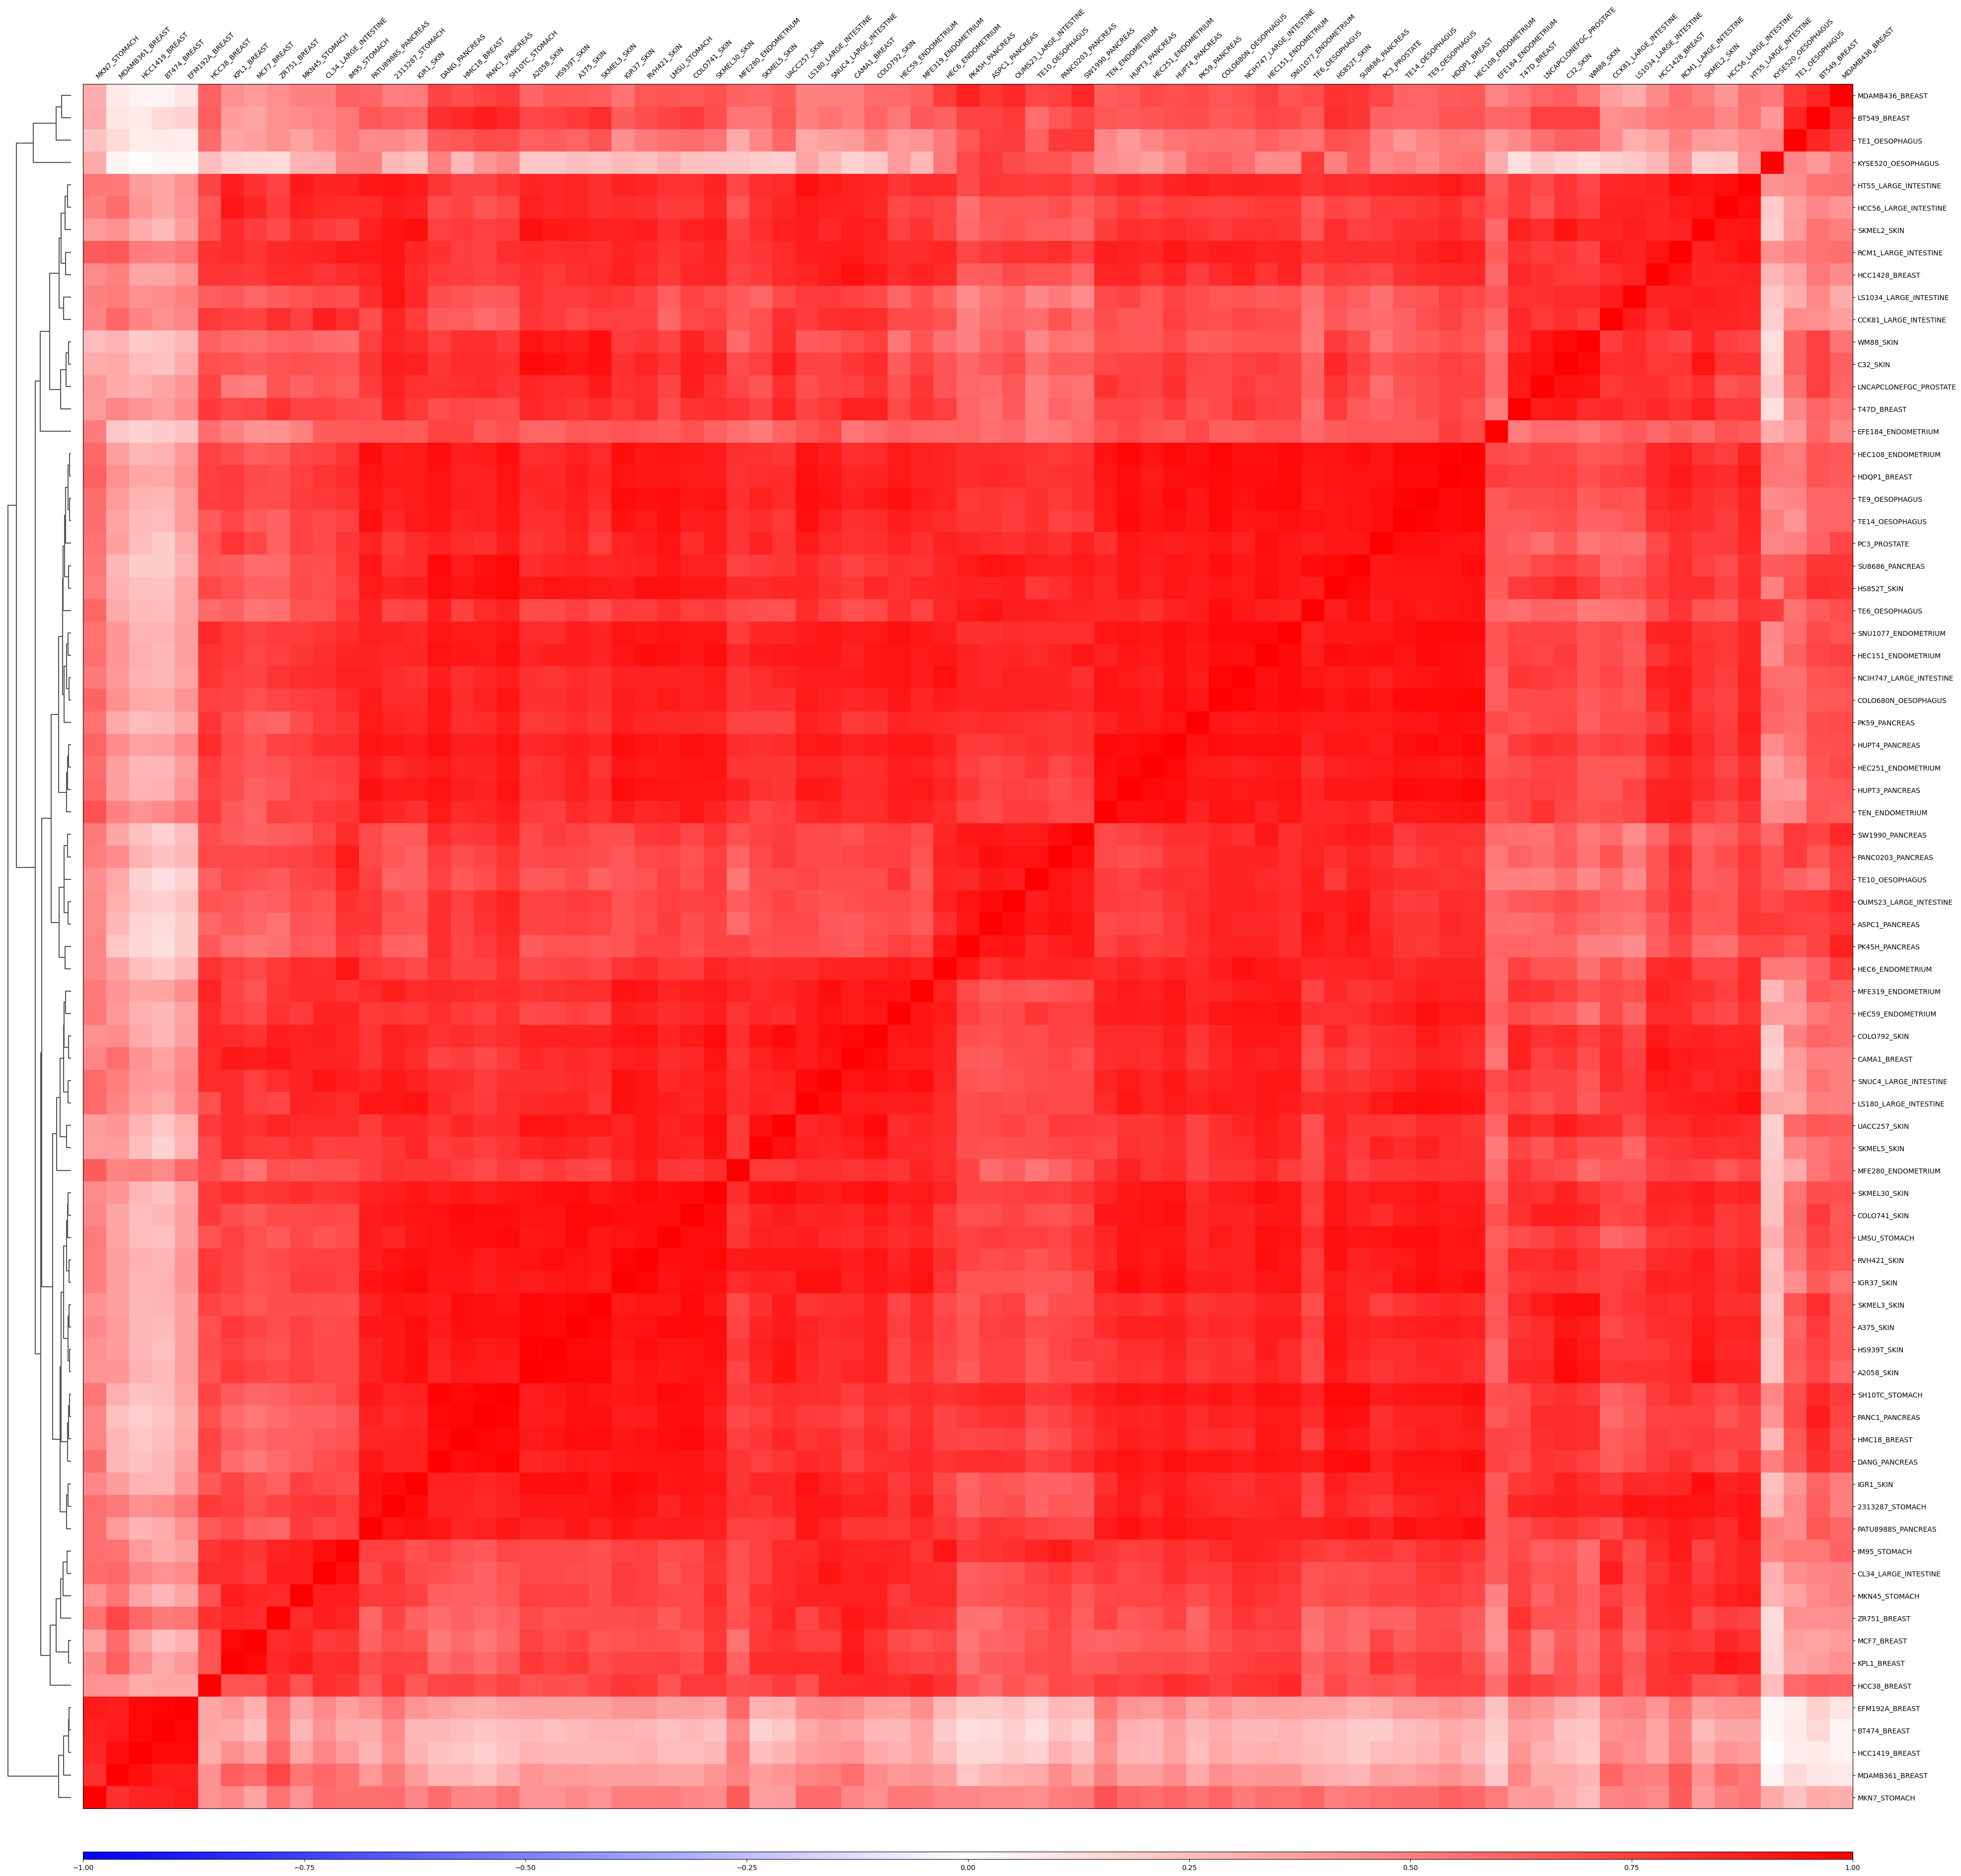

In [62]:
Gene_set_HER2 = ['CARM1','EGFR','EP300','ERBB2','ERBB3','ERBB4','ESR1','GRB2','GRIP1','HRAS','IL6','IL6R','IL6ST','MAP2K1','MAPK1','MAPK3','PIK3CA','PIK3CG','PIK3R1','RAF1','SHC1','SOS1','STAT3']

cancer_list_Trastuzumab = ['Breast Cancer', 'Gastric Cancer', 'Colon/Colorectal Cancer',
                           'Endometrial/Uterine Cancer', 'Esophageal Cancer',
                           'Skin Cancer', 'Prostate Cancer','Pancreatic Cancer']

pdata_Trastuzumab_2 = pdata[pdata.obs['Indication'].isin(cancer_list_Trastuzumab),
                            pdata.var.index.isin(Gene_set_HER2)]

sc.tl.dendrogram(adata=pdata_Trastuzumab_2, groupby='CellLine', inplace=True)
sc.pl.correlation_matrix(adata=pdata_Trastuzumab_2, groupby='CellLine')

In [85]:
df_pdata_Trastuzumab = pd.DataFrame(pdata_Trastuzumab_2.X)
df_pdata_Trastuzumab.index = pdata_Trastuzumab_2.obs_names
df_pdata_Trastuzumab.columns = pdata_Trastuzumab_2.var_names
correlation_matrix = df_pdata_Trastuzumab.T.corr()

# Get upper triangular part of the correlation matrix
upper_tri = np.triu(correlation_matrix, k=1)

# Extract unique values, excluding diagonal (1.0)
unique_correlations = np.unique(upper_tri[upper_tri != 0])

In [86]:
def extract_unique_correlations(correlation_matrix):
    # Assuming you have your correlation_matrix

    # Get upper triangular part of the correlation matrix
    upper_tri = np.triu(correlation_matrix, k=1)

    # Get row and column indices of non-zero elements in upper triangle
    row_indices, col_indices = np.nonzero(upper_tri)

    # Extract unique correlation values
    unique_correlations = upper_tri[row_indices, col_indices]

    # Get corresponding variable names using indices
    variable_names = correlation_matrix.columns  # Get column names
    variable_pairs = [(variable_names[i], variable_names[j])
                      for i, j in zip(row_indices, col_indices)]

    # Create a DataFrame
    df_correlations = pd.DataFrame({
        'Variable 1': [pair[0] for pair in variable_pairs],
        'Variable 2': [pair[1] for pair in variable_pairs],
        'Correlation': unique_correlations
    })

    return(df_correlations)

In [87]:
unique_correlations_pdata_Trastuzumab = extract_unique_correlations(correlation_matrix)

In [88]:
unique_correlations_pdata_Trastuzumab.to_csv('/content/unique_correlations_pdata_Trastuzumab.csv')

In [89]:
unique_correlations_pdata_Trastuzumab.sort_values(by='Correlation', ascending=False).head(50)

,Variable 1,Variable 2,Correlation
102,6_A2058_SKIN,9_HS939T_SKIN,0.983953
2607,6_PANC1_PANCREAS,22_SH10TC_STOMACH,0.981638
2900,19_TE14_OESOPHAGUS,15_TE9_OESOPHAGUS,0.979670
954,9_DANG_PANCREAS,22_SH10TC_STOMACH,0.977570
1330,16_HDQP1_BREAST,18_HEC108_ENDOMETRIUM,0.977127
1436,18_HEC108_ENDOMETRIUM,15_TE9_OESOPHAGUS,0.975856
76,6_A2058_SKIN,6_A375_SKIN,0.975098
1433,18_HEC108_ENDOMETRIUM,19_TE14_OESOPHAGUS,0.973547
725,22_COLO680N_OESOPHAGUS,18_HEC108_ENDOMETRIUM,0.973171
752,22_COLO680N_OESOPHAGUS,18_NCIH747_LARGE_INTESTINE,0.972419


In [94]:
unique_correlations_pdata_Trastuzumab[
    (unique_correlations_pdata_Trastuzumab['Variable 1'].str.contains('MKN7'))|
    (unique_correlations_pdata_Trastuzumab['Variable 2'].str.contains('MKN7'))
].sort_values(by='Correlation', ascending=False).head(20)

,Variable 1,Variable 2,Correlation
1066,10_EFM192A_BREAST,10_MKN7_STOMACH,0.894947
340,22_BT474_BREAST,10_MKN7_STOMACH,0.865554
1126,10_HCC1419_BREAST,10_MKN7_STOMACH,0.854928
2335,16_MDAMB361_BREAST,10_MKN7_STOMACH,0.805905
2516,10_MKN7_STOMACH,22_TEN_ENDOMETRIUM,0.673891
2400,9_MFE280_ENDOMETRIUM,10_MKN7_STOMACH,0.639765
2499,10_MKN7_STOMACH,22_RCM1_LARGE_INTESTINE,0.637726
1356,16_HDQP1_BREAST,10_MKN7_STOMACH,0.624532
751,22_COLO680N_OESOPHAGUS,10_MKN7_STOMACH,0.607492
1906,16_HUPT4_PANCREAS,10_MKN7_STOMACH,0.601919


In [95]:
unique_correlations_pdata_Trastuzumab[
    (unique_correlations_pdata_Trastuzumab['Variable 1'].str.contains('HCC1419'))|
    (unique_correlations_pdata_Trastuzumab['Variable 2'].str.contains('HCC1419'))
].sort_values(by='Correlation', ascending=False).head(20)

,Variable 1,Variable 2,Correlation
1035,10_EFM192A_BREAST,10_HCC1419_BREAST,0.964684
309,22_BT474_BREAST,10_HCC1419_BREAST,0.964392
1121,10_HCC1419_BREAST,16_MDAMB361_BREAST,0.944060
1126,10_HCC1419_BREAST,10_MKN7_STOMACH,0.854928
1155,10_HCC1419_BREAST,10_ZR751_BREAST,0.591590
1135,10_HCC1419_BREAST,22_RCM1_LARGE_INTESTINE,0.508674
1123,10_HCC1419_BREAST,9_MFE280_ENDOMETRIUM,0.500096
587,16_CCK81_LARGE_INTESTINE,10_HCC1419_BREAST,0.482083
654,10_CL34_LARGE_INTESTINE,10_HCC1419_BREAST,0.474299
1114,10_HCC1419_BREAST,10_KPL1_BREAST,0.442683
